<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/vae_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE for classification

In [1]:
# Install the library

!pip install rapidae

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score
from keras import utils
from rapidae.data import load_MNIST
from rapidae.models.base import VAE_Encoder_Conv_MNIST, VAE_Decoder_Conv_MNIST
from rapidae.models import VAE
from rapidae.pipelines import TrainingPipeline
from rapidae.evaluate import evaluate, plot_latent_space

### Data

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten digit images.

Train and test data are normalized.

We also need to convert the labels into one-hot encoding.

In [4]:
# Load MNIST dataset
data = load_MNIST()

y_train_orig = data["y_train"]
y_test_orig = data["y_test"]

x_train = data["x_train"].astype("float32") / 255
x_test = data["x_test"].astype("float32") / 255

# Obtaint number of clasess
n_classes = len(set(data["y_train"]))

# Convert labels to categorical
y_train = utils.to_categorical(data["y_train"], n_classes)
y_test = utils.to_categorical(data["y_test"], n_classes)

2024-04-16 11:55:11 [INFO]: Downloading train-images-idx3-ubyte.gz...
2024-04-16 11:55:11 [INFO]: Downloading train-labels-idx1-ubyte.gz...
2024-04-16 11:55:11 [INFO]: Downloading t10k-images-idx3-ubyte.gz...
2024-04-16 11:55:11 [INFO]: Downloading t10k-labels-idx1-ubyte.gz...
2024-04-16 11:55:12 [INFO]: Deleting MNIST data...


### Model

In this example we are using a variational autoencoder with a classifier attached to its latent space. Weights have been included for the classifier loss as well as for the vae loss in order to increase the classifying capability of the model.

In [ ]:
# Model creation
model = VAE(input_dim=x_train.shape[1:], 
            latent_dim=10, 
            downstream_task='classification',
            encoder=VAE_Encoder_Conv_MNIST, 
            decoder=VAE_Decoder_Conv_MNIST, 
            n_classes=n_classes,
            weight_vae=0.25, 
            weight_clf=20)

### Training

In [8]:
pipe = TrainingPipeline(name='vae_clf_MNIST',
                        model=model, 
                        num_epochs=20, 
                        batch_size=128)

trained_model = pipe(x=x_train, y=y_train)

2024-04-16 11:57:36 [INFO]: +++ vae_clf_MNIST +++
2024-04-16 11:57:36 [INFO]: Creating folder in ./output_dir/vae_clf_MNIST_2024-04-16_11-57
2024-04-16 11:57:36 [INFO]: 
TRAINING STARTED
	Backend: tensorflow
	Eager mode: False
	Validation data available: False
	Callbacks set: ['EarlyStopping', 'ModelCheckpoint'] 



Epoch 1/20

Epoch 1: loss improved from inf to 217.04568, saving model to ./output_dir/vae_clf_MNIST_2024-04-16_11-57/model.weights.h5
469/469 - 39s - 83ms/step - clf_loss: 1.2400 - kl_loss: 11.2361 - loss: 217.0457 - reconstruction_loss: 180.9778
Epoch 2/20

Epoch 2: loss improved from 217.04568 to 141.77737, saving model to ./output_dir/vae_clf_MNIST_2024-04-16_11-57/model.weights.h5
469/469 - 34s - 73ms/step - clf_loss: 0.3085 - kl_loss: 17.4879 - loss: 141.7774 - reconstruction_loss: 118.1191
Epoch 3/20

Epoch 3: loss improved from 141.77737 to 129.72461, saving model to ./output_dir/vae_clf_MNIST_2024-04-16_11-57/model.weights.h5
469/469 - 34s - 73ms/step - clf_loss: 0.2008 - kl_loss: 18.0053 - loss: 129.7246 - reconstruction_loss: 107.6972
Epoch 4/20

Epoch 4: loss improved from 129.72461 to 124.90231, saving model to ./output_dir/vae_clf_MNIST_2024-04-16_11-57/model.weights.h5
469/469 - 32s - 69ms/step - clf_loss: 0.1669 - kl_loss: 18.1217 - loss: 124.9023 - reconstruction_loss:

2024-04-16 12:08:55 [INFO]: Restoring best model
2024-04-16 12:08:55 [INFO]: Best model restored


### Evaluation

We can now display the label clusters in the latent space.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


2024-04-16 12:30:55 [INFO]: Latent space > 2. Performing dimensionality reduction using t-SNE...


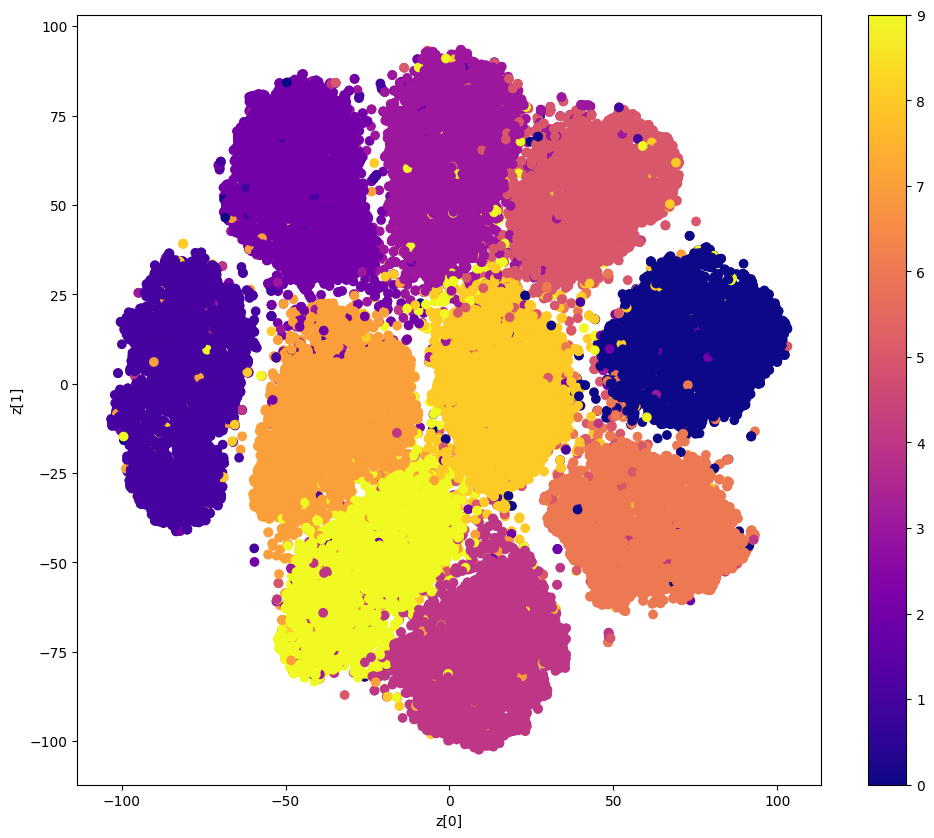

In [13]:
outputs = trained_model.predict(x_train)
plot_latent_space(outputs['z'], y_train_orig)

Let's check the classification metrics with the classification_report() function from Scikit-Learn and using the evaluate function of Rapidae.

In [14]:
from sklearn.metrics import classification_report

y_test_predict = trained_model.predict(x_test)

print(np.argmax(y_test_predict['clf'], axis=1))
print(np.argmax(y_test, axis=1))

target_names = ['number 0', 'number 1', 'number 2', 'number 3',
                'number 4', 'number 5', 'number 6', 'number 7', 'number 8', 'number 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(
    y_test_predict['clf'], axis=1), target_names=target_names))

  7/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step 

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
              precision    recall  f1-score   support

    number 0       0.97      0.99      0.98       980
    number 1       0.99      0.99      0.99      1135
    number 2       0.97      0.97      0.97      1032
    number 3       0.97      0.95      0.96      1010
    number 4       0.98      0.97      0.97       982
    number 5       0.95      0.96      0.95       892
    number 6       0.98      0.97      0.97       958
    number 7       0.98      0.97      0.97      1028
    number 8       0.96      0.96      0.96       974
    number 9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [15]:
y_hat = trained_model.predict(x_test)

evaluate(y_true=np.argmax(y_test, axis=1),
         y_hat=np.argmax(y_hat['clf'], axis=1),
         sel_metric=accuracy_score)

  7/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


2024-04-16 12:58:12 [INFO]: Using Scikit-learn metric...


test set results: [
	 accuracy_score: 0.9695 
]


0.9695